# Cost function for heavy-tailed noise

In [1]:
from __future__ import print_function

import numpy as np
from sklearn.linear_model import Ridge
from flexible_linear import FlexibleLinearRegression

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

np.random.seed(1)

## Generate some data

Our "ground truth" data is a simple linear function.

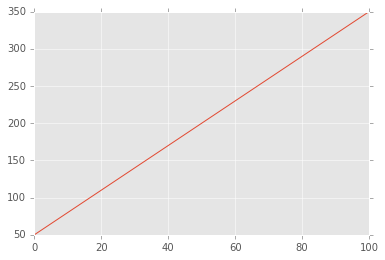

In [2]:
N = 500
A = 50
B = 3
x = np.linspace(0, 100, N, dtype=float)
X = x.reshape(-1, 1)  # scikit-learn wants 2d arrays
y = A + B * x
plt.plot(x, y, '-')

### Let's try adding Gaussian (normal) noise...

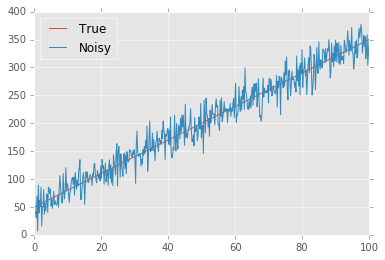

In [3]:
y_gauss = y + 20*np.random.randn(N)
plt.plot(x, y, '-', x, y_gauss, '-')
plt.legend(['True', 'Noisy'], loc='upper left')

### ... or some Cauchy (heavy-tailed) noise

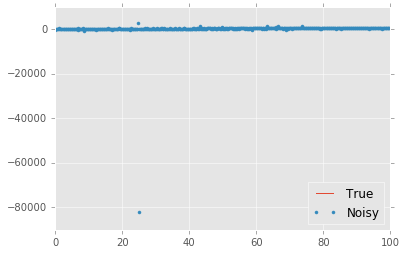

In [4]:
y_cauchy = y + 20*np.random.standard_cauchy(N)
plt.plot(x, y, '-', x, y_cauchy, '.')
plt.legend(['True', 'Noisy'], loc='lower right')

## Trying to recover the linear function using Ridge regression

### Gaussian noise

For Gaussian noise the recovery works fairly well.

     True: 50.000 + 3.000 * x
Recovered: 51.598 + 2.989 * x


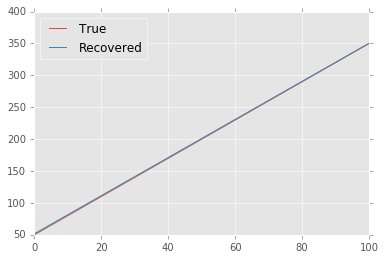

In [5]:
clf = Ridge()
clf.fit(X, y_gauss)
pred = clf.predict(X)
plt.plot(x, y, '-', x, pred, '-')
plt.legend(['True', 'Recovered'], loc='upper left')
print("     True: %.3f + %.3f * x" % (A, B))
print("Recovered: %.3f + %.3f * x" % (clf.intercept_, clf.coef_[0]))

### Cauchy noise

Let's try the same with the Cauchy noise.

     True: 50.000 + 3.000 * x
Recovered: -362.909 + 8.056 * x


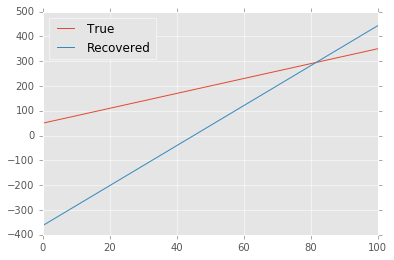

In [6]:
clf = Ridge()
clf.fit(X, y_cauchy)
pred = clf.predict(X)
plt.plot(x, y, '-', x, pred, '-')
plt.legend(['True', 'Recovered'], loc='upper left')
print("     True: %.3f + %.3f * x" % (A, B))
print("Recovered: %.3f + %.3f * x" % (clf.intercept_, clf.coef_[0]))

That looks much less impressive. The problem is that the squared-$\ell^2$-norm minimized by Ridge regression is too sensitive to outliers.

## Using a less sensitive cost function

Let
$$z_i = (X \cdot W - y)_i$$

denote the residuals. Instead of the usual least-squares approach of minimizing

$$\min_W ||z||_{\ell^2}^2 = \frac12 \sum_i |z_i|^2 \,, $$

let's try to minimize the $\ell^1$ norm

$$\min_W ||z||_{\ell^1} = \sum_i |z_i|$$

instead. Alternatively, since that is not smooth, we could try to minimize an objective like

$$ \min_W \eta^2 \sum_i \left( \sqrt{ 1 + \left( \frac{|z_i|}{\eta} \right)^2 } - 1 \right) \,, $$

where $\eta$ is a positive scale parameter.
This is a *smooth* convex cost function based component-wise on the _Japanese bracket_:

$$ \langle z \rangle := \sqrt{1 + |z|^2} \,. $$

It behaves like the least-squares cost function for $|z| \ll \eta$,
but grows like $O(|z|)$ for $|z| \gg \eta$.
So it gives us the best of $\ell^1$ and squared-$\ell^2$:
The smoothness of squared-$\ell^2$ for small values
and the insensitivity to outliers of $\ell^1$ for large values.

We use a custom `FlexibleLinearRegression` scikit-learn estimator that allows us to try these different cost functions.

**Note:** For simplicity, we omit regularization in the above (and below by setting `C=0.0`). It really does not matter for this toy problem.

### squared $\ell^2$ cost

This is pretty much the same as `Ridge` above (minus the regularization). It performs horribly.

     True: 50.000 + 3.000 * x
Recovered: -362.910 + 8.056 * x


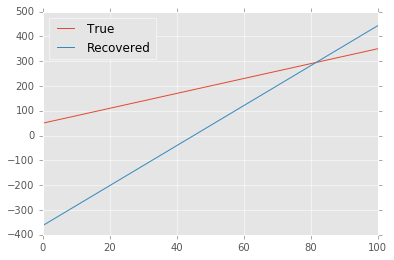

In [7]:
clf = FlexibleLinearRegression(cost_func='l2', C=0.0)
clf.fit(X, y_cauchy)
pred = clf.predict(X)
plt.plot(x, y, '-', x, pred, '-')
plt.legend(['True', 'Recovered'], loc='upper left')
print("     True: %.3f + %.3f * x" % (A, B))
print("Recovered: %.3f + %.3f * x" % (clf.coef_[0], clf.coef_[1]))

### $\ell^1$ cost

If we switch to the $\ell^1$ cost, we start to get very good results!

     True: 50.000 + 3.000 * x
Recovered: 47.083 + 3.007 * x


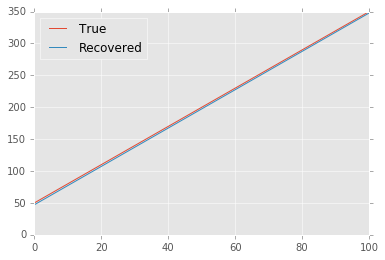

In [8]:
clf = FlexibleLinearRegression(cost_func='l1', C=0.0)
clf.fit(X, y_cauchy)
pred = clf.predict(X)
plt.plot(x, y, '-', x, pred, '-')
plt.legend(['True', 'Recovered'], loc='upper left')
print("     True: %.3f + %.3f * x" % (A, B))
print("Recovered: %.3f + %.3f * x" % (clf.coef_[0], clf.coef_[1]))

### Japanese cost

If we switch to the *Japanese bracket* cost, we get results just as good. For this simple example, the $\ell^1$ cost already gave us good answers, but for more complex problems the smoothness of the *Japanese bracket* may make it a numerically safer choice.

     True: 50.000 + 3.000 * x
Recovered: 47.135 + 2.998 * x


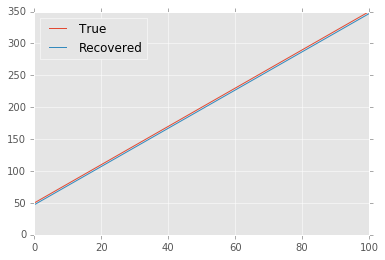

In [9]:
clf = FlexibleLinearRegression(cost_func='japanese', C=0.0, cost_opts={'eta': 10.0})
clf.fit(X, y_cauchy)
pred = clf.predict(X)
plt.plot(x, y, '-', x, pred, '-')
plt.legend(['True', 'Recovered'], loc='upper left')
print("     True: %.3f + %.3f * x" % (A, B))
print("Recovered: %.3f + %.3f * x" % (clf.coef_[0], clf.coef_[1]))